In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [4]:
#Organizing the dataset
data_dir = '/raid/ee-mariyam/maryam/ayush/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

import json

# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
included_subdirs = ['Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']
image_datasets = {}
for x in ['train', 'val']:
    dir_path = os.path.join(data_dir, x)
    included_paths = [os.path.join(dir_path, subdir) for subdir in included_subdirs]
    dataset = datasets.ImageFolder(dir_path, transform=data_transforms[x])

    # Filter samples and update class indexing
    filtered_samples = [
        (path, class_idx)
        for path, class_idx in dataset.samples
        if os.path.dirname(path) in included_paths
    ]
    if len(filtered_samples) == 0:
        raise ValueError(f"No samples found in the included subdirectories for '{x}' split.")

    filtered_paths, filtered_targets = zip(*filtered_samples)
    unique_targets = sorted(set(filtered_targets))
    target_mapping = {class_idx: i for i, class_idx in enumerate(unique_targets)}

    filtered_targets = [target_mapping[class_idx] for class_idx in filtered_targets]
    dataset.samples = list(zip(filtered_paths, filtered_targets))
    dataset.targets = filtered_targets
    dataset.classes = [dataset.classes[class_idx] for class_idx in unique_targets]

    image_datasets[x] = dataset

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


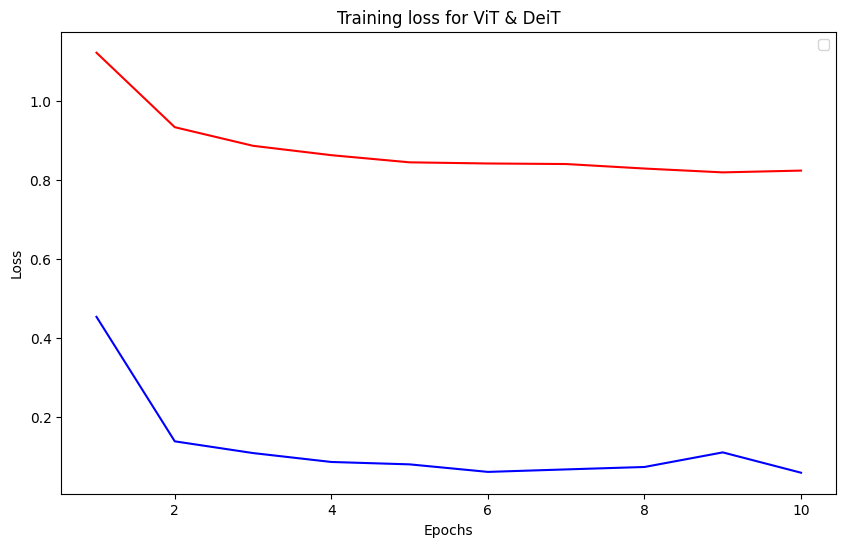

In [25]:
import matplotlib.pyplot as plt

# Replace these with your actual training and testing loss values
train_loss_vit = [0.4538899557357961,0.13899769421134675,0.10930365776786437,0.08678514792041464,0.08072703254235152,0.061684021096072766,0.06798156103231831,0.07410858391558976,0.11102276903853475,0.0595905790658115]
train_loss_deit = [1.1221 ,0.9337 ,0.8866 ,0.8629 ,0.8448 , 0.8419 ,0.8405 ,0.8291 ,0.8194, 0.8239 ]

epochs = range(1, len(train_loss_vit) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_vit, 'b')
plt.plot(epochs, train_loss_deit, 'r')
plt.title('Training loss for ViT & DeiT')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


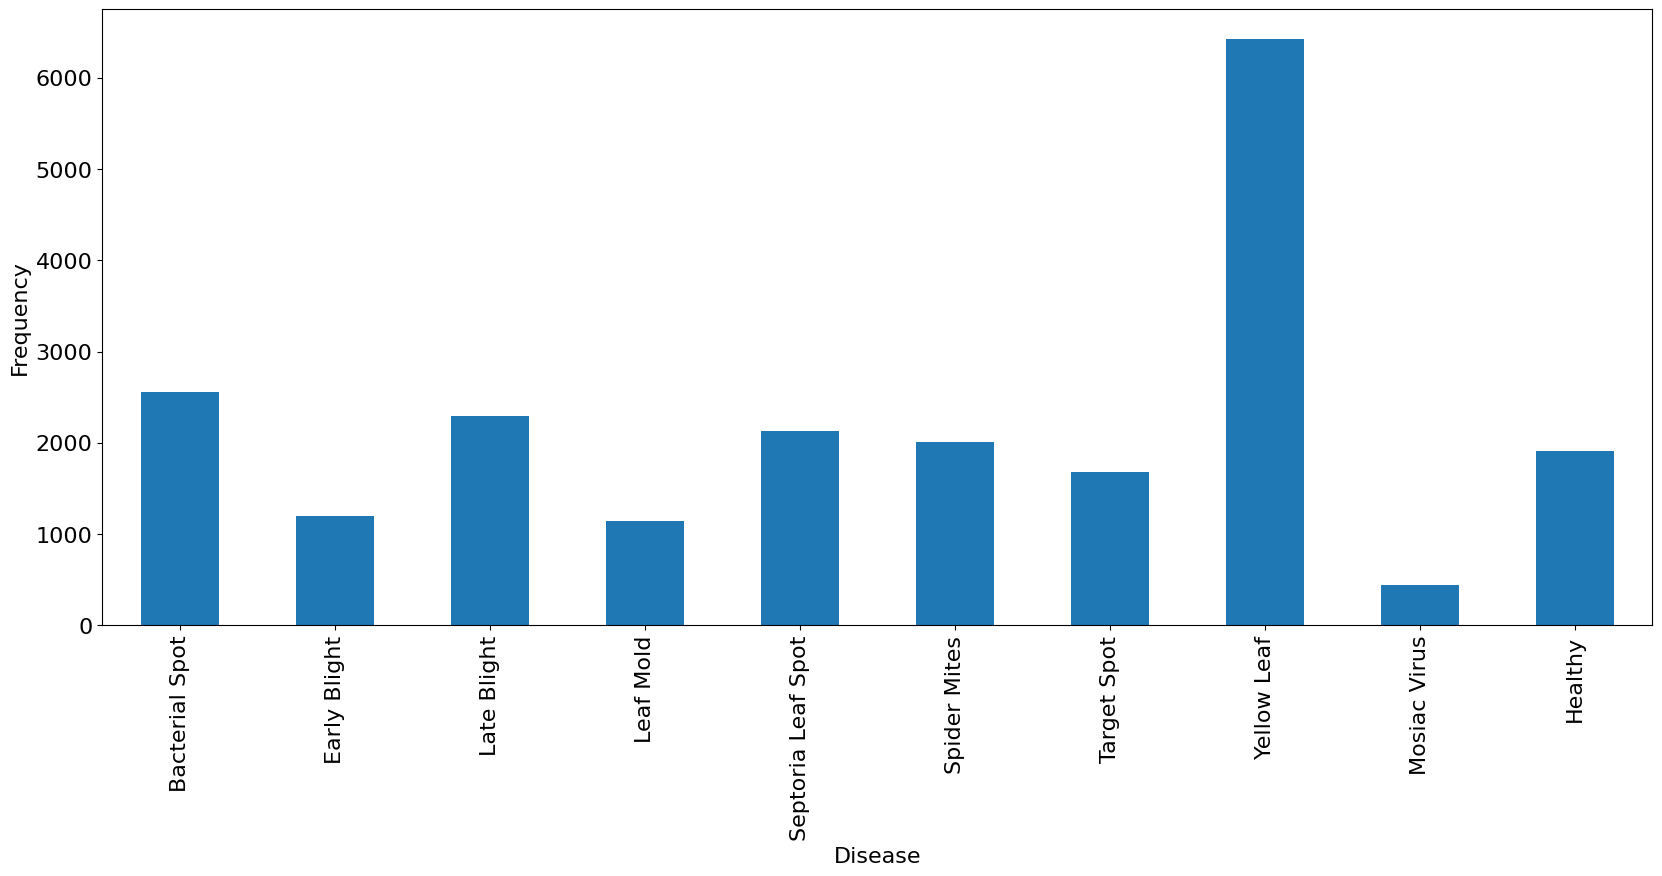

In [11]:
from collections import Counter
import pandas as pd

counts1 = Counter(image_datasets['train'].targets)
counts2 = Counter(image_datasets['val'].targets)
df = pd.DataFrame(columns=['Frequency'])

for i in counts1:
    df.loc[class_names[i]] = counts1[i]+counts2[i]

counts = Counter(image_datasets['val'].targets)

for i in counts:
    df.loc[class_names[i]] = df.loc[class_names[i]] + counts[i]
custom_xticks = ["Bacterial Spot", "Early Blight", "Late Blight", "Leaf Mold", "Septoria Leaf Spot", "Spider Mites", "Target Spot", "Yellow Leaf", "Mosiac Virus", "Healthy"]
df.index = custom_xticks
ax = df.plot.bar(figsize=(20, 8), legend=False)
ax.set_xticklabels(custom_xticks, fontsize=16)  # Set the custom xticks and adjust fontsize
plt.yticks(fontsize=16)
# Add axis labels
ax.set_xlabel("Disease", fontsize=16)  # Add an x-axis label
ax.set_ylabel("Frequency", fontsize=16)
plt.show()

In [6]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import ViTFeatureExtractor, ViTForImageClassification

# Load the pre-trained ViT model and feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.classifier = nn.Linear(model.config.hidden_size, 10)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [9]:
train_loader=dataloaders['train']

In [10]:
import time

num_classes = 10  # Change this according to your dataset
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(logits, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch 1/10, Loss: 0.3907491370298705, Train Accuracy: 90.82%
Epoch 2/10, Loss: 0.12329008506999893, Train Accuracy: 96.45%
Epoch 3/10, Loss: 0.08107749188656581, Train Accuracy: 97.62%
Epoch 4/10, Loss: 0.07147074933624366, Train Accuracy: 97.87%
Epoch 5/10, Loss: 0.0678127387139414, Train Accuracy: 97.93%
Epoch 6/10, Loss: 0.056995628619500034, Train Accuracy: 98.26%
Epoch 7/10, Loss: 0.061402466968418314, Train Accuracy: 98.07%
Epoch 8/10, Loss: 0.05082950666866644, Train Accuracy: 98.41%
Epoch 9/10, Loss: 0.04942397929825257, Train Accuracy: 98.34%
Epoch 10/10, Loss: 0.043690041825687004, Train Accuracy: 98.66%
Training finished, took 5050.55s


In [11]:
test_loader=dataloaders['val']

In [13]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = 100 * correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.45%


In [ ]:
# Size and number of parameters of model
param_size = 0
num_parameters = 0
for param in model.parameters():
    num_parameters += 1
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 327.325MB


In [ ]:
print(num_parameters)

200
